In [16]:
import pandas as pd
import json  
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use("ggplot")

In [4]:
import urllib.request
url = "https://api.nomics.com/v1/market-cap/history?key=7b5a32aeef57b5385383f0225ec93d50&start=2020-01-01T00%3A00%3A00Z"
total_cap = urllib.request.urlopen(url).read()
total_market_cap_df = pd.read_json(total_cap)  #reading json data for total maerket cap into a pandas dataframe

In [5]:
total_market_cap_df.rename(columns={"market_cap": "total_market_cap"}, inplace=True) # renaming columns

In [11]:
btc_df = pd.read_csv("btc-data.csv") # reading bitcoin data into a pandas df
btc_df = btc_df[btc_df['snapped_at'] >= "2020-01-01 00:00:00"]   # chopping off data before Jan 2020
btc_df["market_cap"] = btc_df["market_cap"].apply(lambda x: '{:.2f}'.format(x)).astype(float).astype(int)  # supressing scientific notations

In [12]:
# concatenating two dfs to calculate bitcoin market capitalization dominance 
total_market_cap_df.reset_index(drop=True, inplace=True)
btc_df.reset_index(drop=True, inplace=True)
btc_dominance_df = pd.concat([total_market_cap_df, btc_df],axis = 1)  

In [18]:
btc_dominance_df["btc_dominance"] = btc_dominance_df["market_cap"] / btc_dominance_df["total_market_cap"] # dominance column generated

btc_dominance_df["timestamp"] = btc_dominance_df["timestamp"].dt.date  # keeping only date part from timestamp

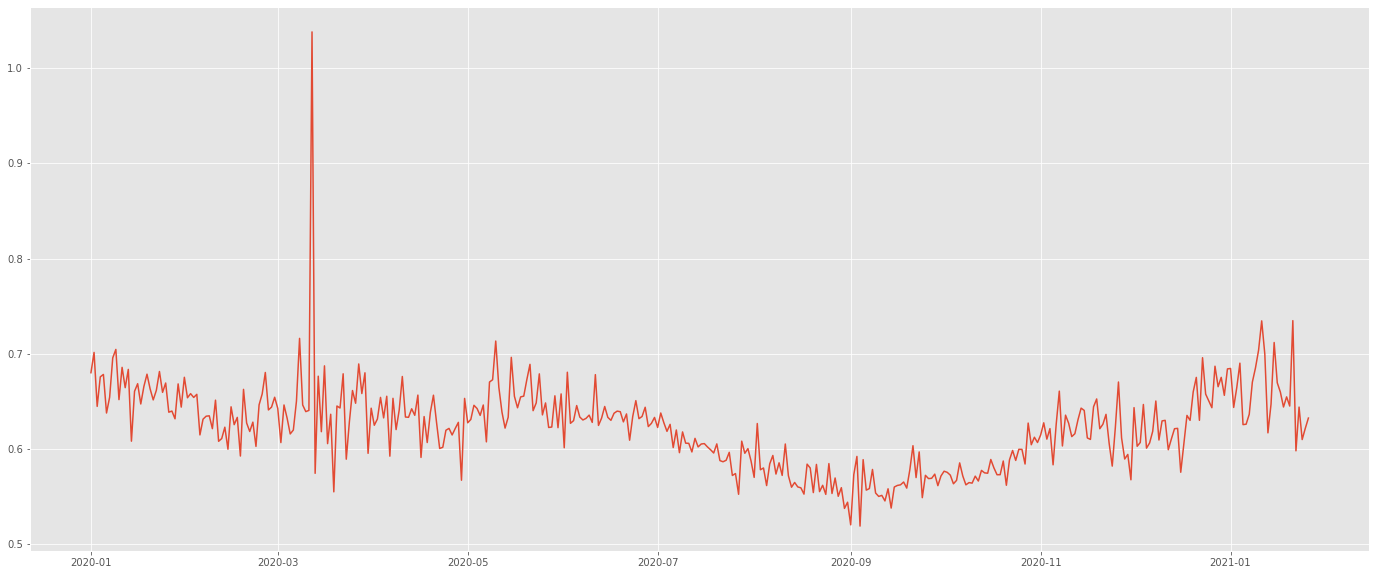

In [20]:
figure(figsize=(24, 10))
_ = plt.plot(btc_dominance_df["timestamp"],btc_dominance_df["btc_dominance"] )